<a href="https://colab.research.google.com/github/Ksenia869/LLM/blob/main/lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 51.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import numpy as np
import warnings
import sklearn
import keras
import nltk
import re
import codecs
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3

Для анализа взяла датасет с отзывами Russian-language reviews (https://www.kaggle.com/datasets/laytsw/reviews/data)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv('/content/drive/MyDrive/reviews.csv', sep='\t')
df.drop_duplicates(subset=['review'], inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df

review sentiment
0      Продавец так и не отправил товар за 60 дней,хо...  negative
1      ужасный запах. манжет на рукаве пришит неправи...  negative
2      Леггинсы пришли с браком (дырка по шву); разме...  negative
3      Заказ делала в конце июля,а в октябре я товара...  negative
4      Блуза хорошего качества, все швы обработаны, н...  positive
...                                                  ...       ...
87316  доставка быстрая, но сам свитер не понравился,...  neautral
87317  На фото брюки выглядят как с низкой посадкой, ...  neautral
87318                          Не пришло, деньги вернули  neautral
87319  не пришло. деньги вернули только через спор......  negative
87320  Футболка класс, материал тоже класс,плотный не...  positive

[87321 rows x 2 columns]

In [6]:
df.tail()

review sentiment
87316  доставка быстрая, но сам свитер не понравился,...  neautral
87317  На фото брюки выглядят как с низкой посадкой, ...  neautral
87318                          Не пришло, деньги вернули  neautral
87319  не пришло. деньги вернули только через спор......  negative
87320  Футболка класс, материал тоже класс,плотный не...  positive

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87321 entries, 0 to 87320
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     87321 non-null  object
 1   sentiment  87321 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [8]:
df['sentiment'].value_counts()

sentiment
positive    29291
negative    29218
neautral    28812
Name: count, dtype: int64

классы сбалансированные

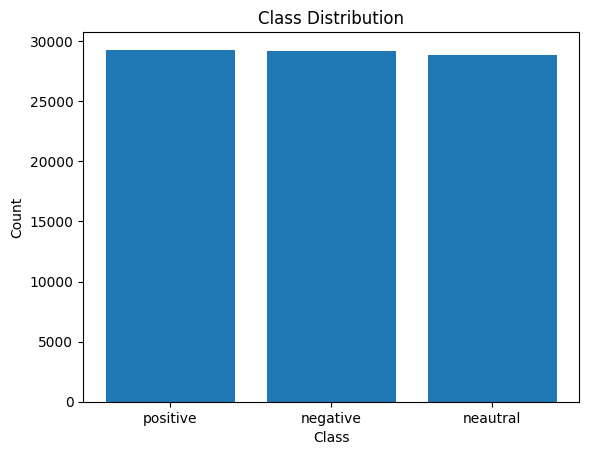

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

x=df.drop(['sentiment'],axis=1)
y=df['sentiment']

count_class = y.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [10]:
class_label = {'positive': 2, 'negative': 1, 'neautral': 0}
df['class_label'] = df['sentiment'].map(class_label)
df

review sentiment  \
0      Продавец так и не отправил товар за 60 дней,хо...  negative   
1      ужасный запах. манжет на рукаве пришит неправи...  negative   
2      Леггинсы пришли с браком (дырка по шву); разме...  negative   
3      Заказ делала в конце июля,а в октябре я товара...  negative   
4      Блуза хорошего качества, все швы обработаны, н...  positive   
...                                                  ...       ...   
87316  доставка быстрая, но сам свитер не понравился,...  neautral   
87317  На фото брюки выглядят как с низкой посадкой, ...  neautral   
87318                          Не пришло, деньги вернули  neautral   
87319  не пришло. деньги вернули только через спор......  negative   
87320  Футболка класс, материал тоже класс,плотный не...  positive   

       class_label  
0                1  
1                1  
2                1  
3                1  
4                2  
...            ...  
87316            0  
87317            0  
87318            0  
87319            1  
87320            2  

[87321 rows x 3 columns]

In [18]:
!pip install nltk

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

воспользовалась регулярными выражениями и стоп-словами, чтобы очистить данные

In [12]:
import nltk
from nltk.corpus import stopwords
import re

def standardize_text(df, content_field, remove_stopwords=True, custom_stopwords=None):
    df = df.copy()
    df[content_field] = df[content_field].str.replace(r"http\S+", "", regex=True)
    df[content_field] = df[content_field].str.replace(r"@\S+", "", regex=True)
    df[content_field] = df[content_field].str.replace(r"[Ёё]", "е", regex=True)
    df[content_field] = df[content_field].str.replace(r"[^А-Яа-яa-zA-Z]", " ")
    df[content_field] = df[content_field].str.replace(r"[^А-Яа-яA-Za-z0-9(),'\`\"\_\n]", " ", regex=True)
    df[content_field] = df[content_field].str.replace(r"[\t\n]", " ", regex=True)
    df[content_field] = df[content_field].str.lower()
    df[content_field] = df[content_field].str.replace(r"\s+", " ", regex=True).str.strip()
    if remove_stopwords:
        russian_stopwords = set(stopwords.words('russian'))
        important_words = {
            'не'
        }
        russian_stopwords = russian_stopwords - important_words
        def remove_stopwords_text(text):
            if not isinstance(text, str):
                return ""

            words = text.split()

            filtered_words = [word for word in words if word not in russian_stopwords]

            filtered_text = ' '.join(filtered_words)

            return filtered_text

        df[content_field] = df[content_field].apply(remove_stopwords_text)
    df[content_field] = df[content_field].str.replace(r"\s+", " ", regex=True).str.strip()

    return df

In [13]:
df_clean = standardize_text(df.copy(), 'review', remove_stopwords=True)

In [14]:
df_clean.tail()

review sentiment  \
87316  доставка быстрая, свитер не понравился, вроде ...  neautral   
87317  фото брюки выглядят низкой посадкой, реальност...  neautral   
87318                          не пришло, деньги вернули  neautral   
87319   не пришло деньги вернули спор доставку заплатила  negative   
87320  футболка класс, материал класс,плотный не прос...  positive   

       class_label  
87316            0  
87317            0  
87318            0  
87319            1  
87320            2

вывела карту слов для каждого класса

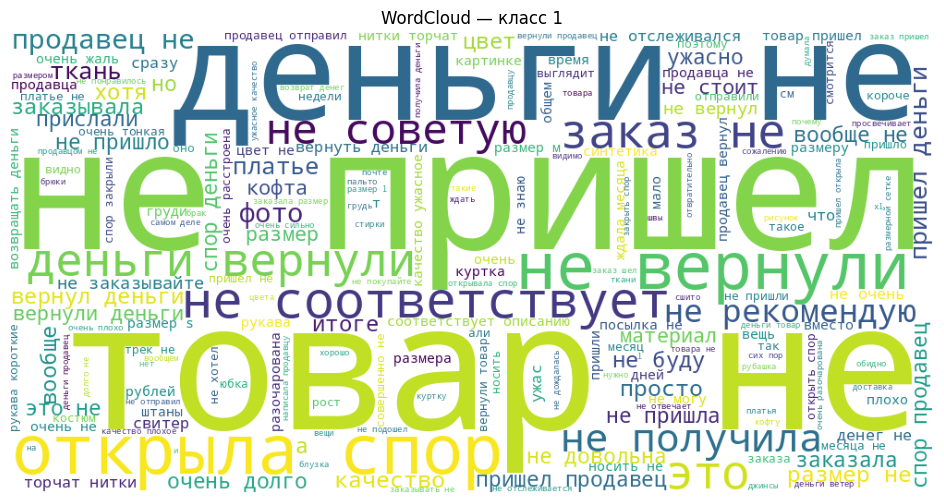

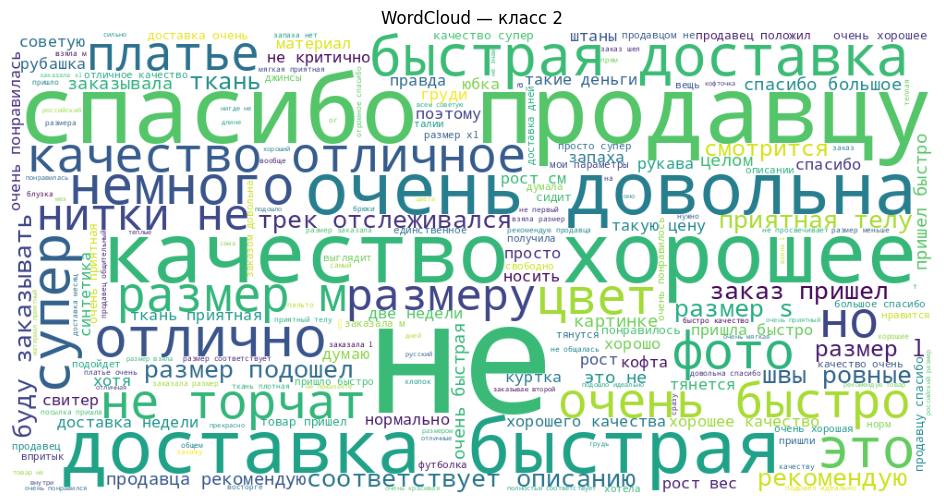

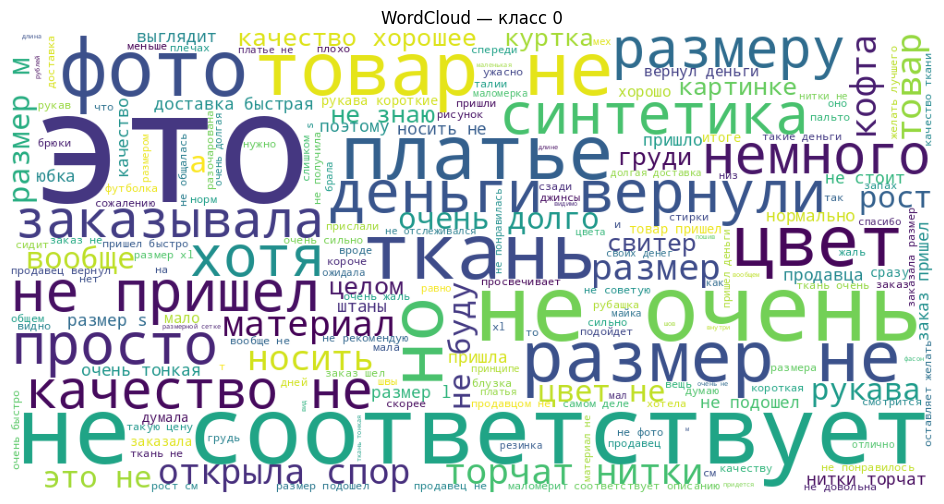

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordcloud(texts, title="WordCloud"):
    text = " ".join(map(str, texts))
    wc = WordCloud(width=1000, height=500, background_color="white").generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()

unique_labels = df_clean["class_label"].unique()
if len(unique_labels) <= 5:
    for lab in unique_labels:
        subset = df_clean[df_clean["class_label"] == lab]["review"].astype(str).tolist()
        if subset:
            plot_wordcloud(subset, title=f"WordCloud — класс {lab}")

использую токенизатор

In [17]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df_clean["tokens"] = df_clean['review'].apply(tokenizer.tokenize)
df_clean.head()

review sentiment  class_label  \
0  продавец не отправил товар 60 дней,хорошо,что ...  negative            1   
1     ужасный запах манжет рукаве пришит неправильно  negative            1   
2  леггинсы пришли браком (дырка шву) размер s ве...  negative            1   
3  заказ делала конце июля,а октябре товара не до...  negative            1   
4  блуза хорошего качества, швы обработаны, ничем...  positive            2   

                                              tokens  
0  [продавец, не, отправил, товар, 60, дней, хоро...  
1  [ужасный, запах, манжет, рукаве, пришит, непра...  
2  [леггинсы, пришли, браком, дырка, шву, размер,...  
3  [заказ, делала, конце, июля, а, октябре, товар...  
4  [блуза, хорошего, качества, швы, обработаны, н...

анализируем дальше

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from  keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df_clean["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_clean["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s общее количество слов, объем словарного запаса %s" % (len(all_words), len(VOCAB)))
print("Максимальная длина комментария %s" % max(sentence_lengths))

1376027 общее количество слов, объем словарного запаса 53037
Максимальная длина комментария 155


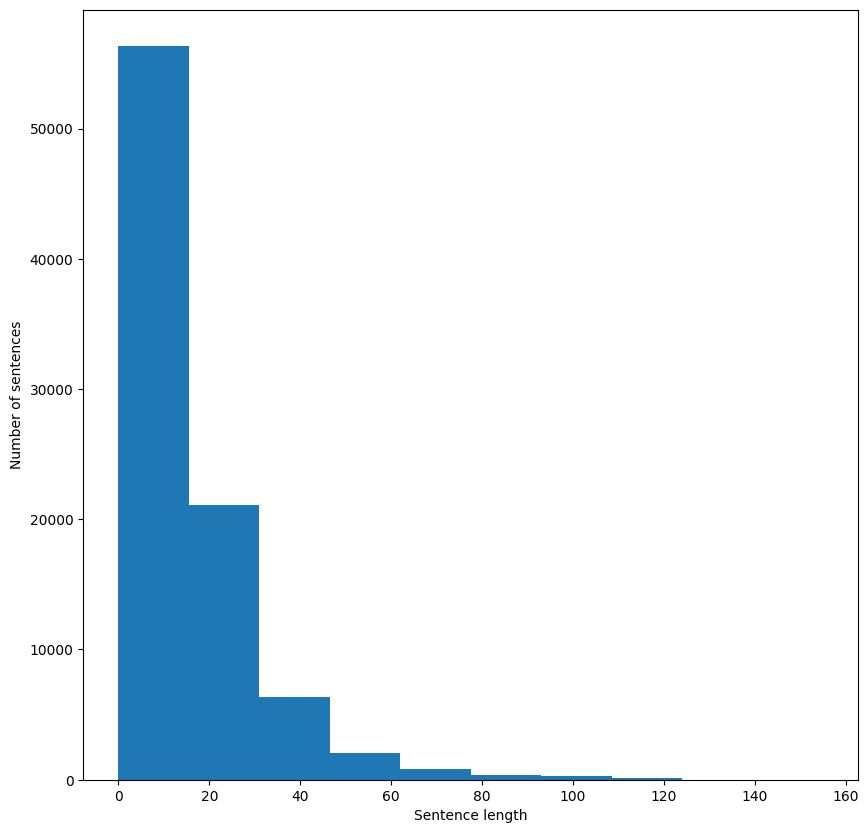

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

в основном отзывы короткие, до 25 слов

### Bag of Words Counts

In [20]:
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer(ngram_range=(1, 3))
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer


list_corpus = df_clean["review"].tolist()
list_labels = df_clean["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

визуализация

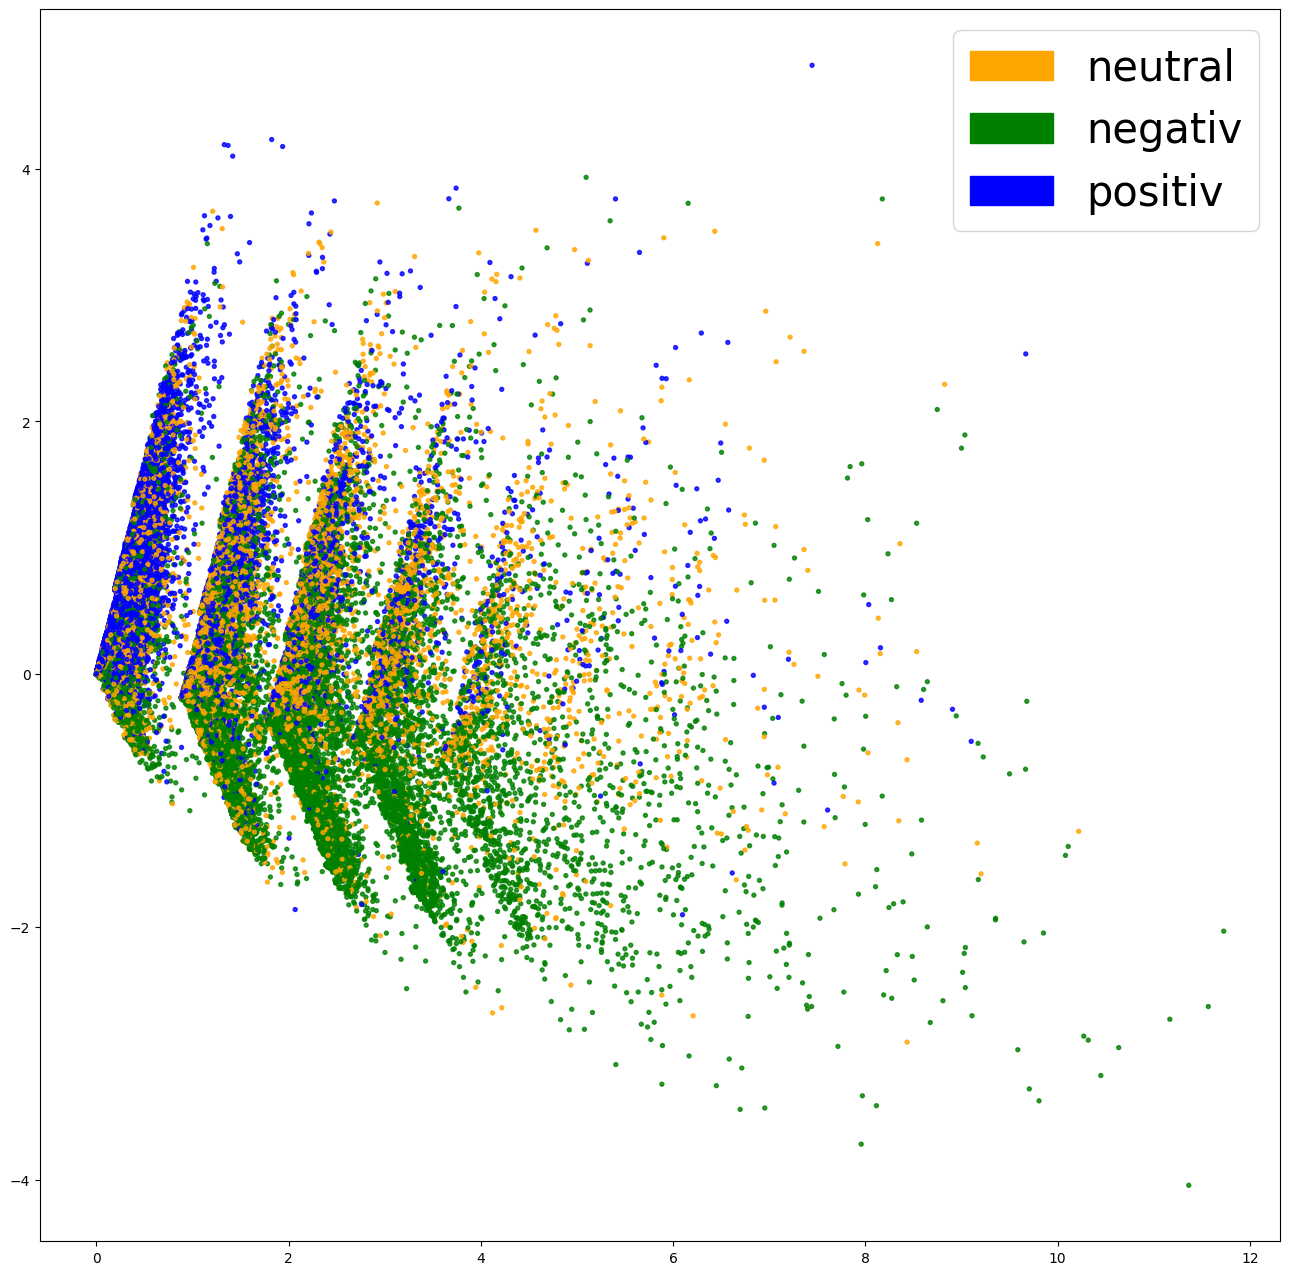

In [21]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','green','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='neutral')
            green_patch = mpatches.Patch(color='green', label='negativ')
            blue_patch = mpatches.Patch(color='blue', label='positiv')
            plt.legend(handles=[red_patch, green_patch, blue_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

визуально заметно различимы классы negative и positive

классификация

In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced', multi_class='multinomial', random_state=42)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


метрики

In [23]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score, classification_report

def get_metrics(y_test, y_predicted):
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')

    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    r2 = r2_score(y_test, y_predicted)

    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1, r2

accuracy, precision, recall, f1, r2 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy, precision, recall, f1,r2))

accuracy = 0.741, precision = 0.744, recall = 0.741, f1 = 0.742, r2 = 0.269


неплохой результат, посмотрим матрицу ошибок

In [24]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

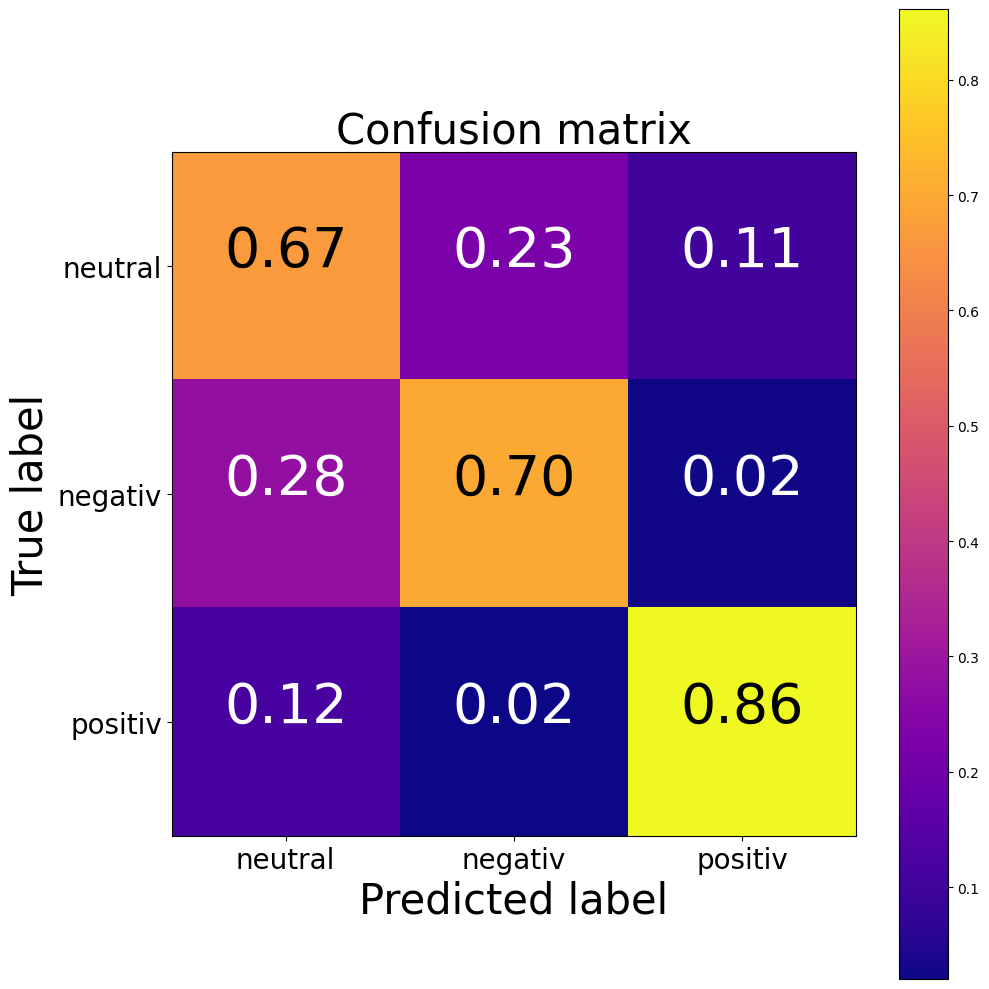

[[3866 1314  633]
 [1631 4107  140]
 [ 683  117 4974]]


In [25]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['neutral','negativ','positiv'], normalize=True, title='Confusion matrix', cmap="plasma")
plt.show()
print(cm)

неплохо, часто ошибается с neutral классом

смотрим какие слова использовались для принятия решений

In [26]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

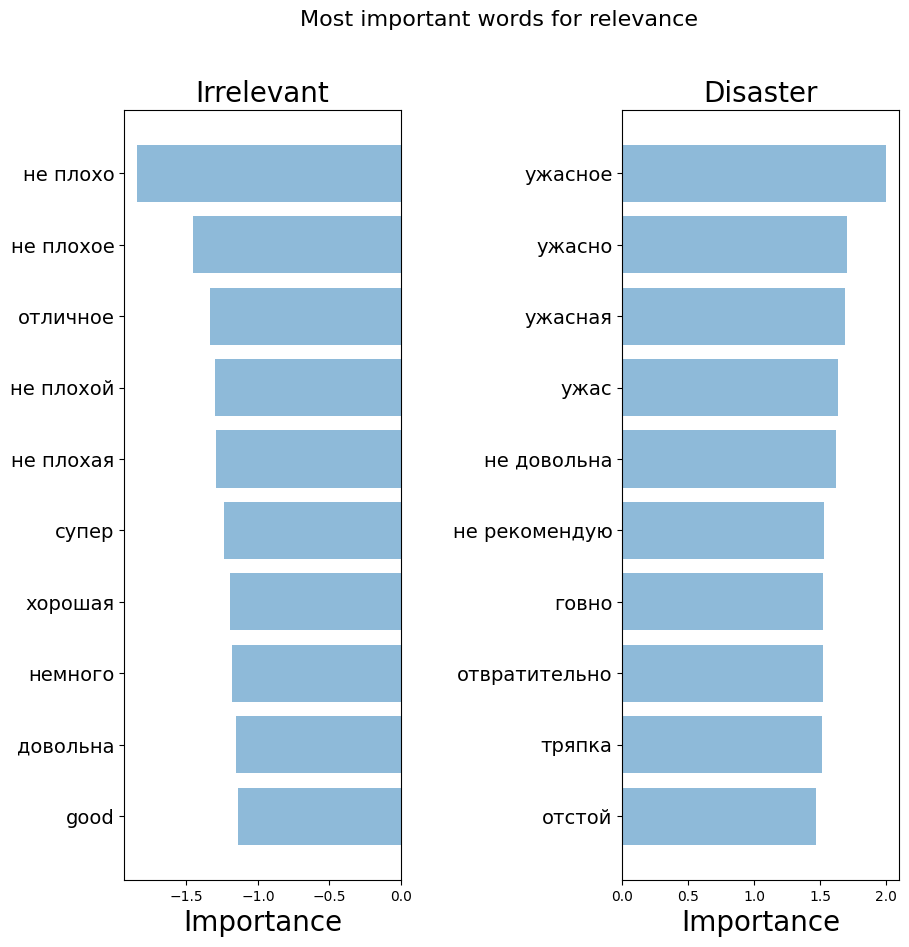

In [27]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

часто встречаютя разные формы слов ужас и не плохо

### TFIDF Bag of Words

In [28]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

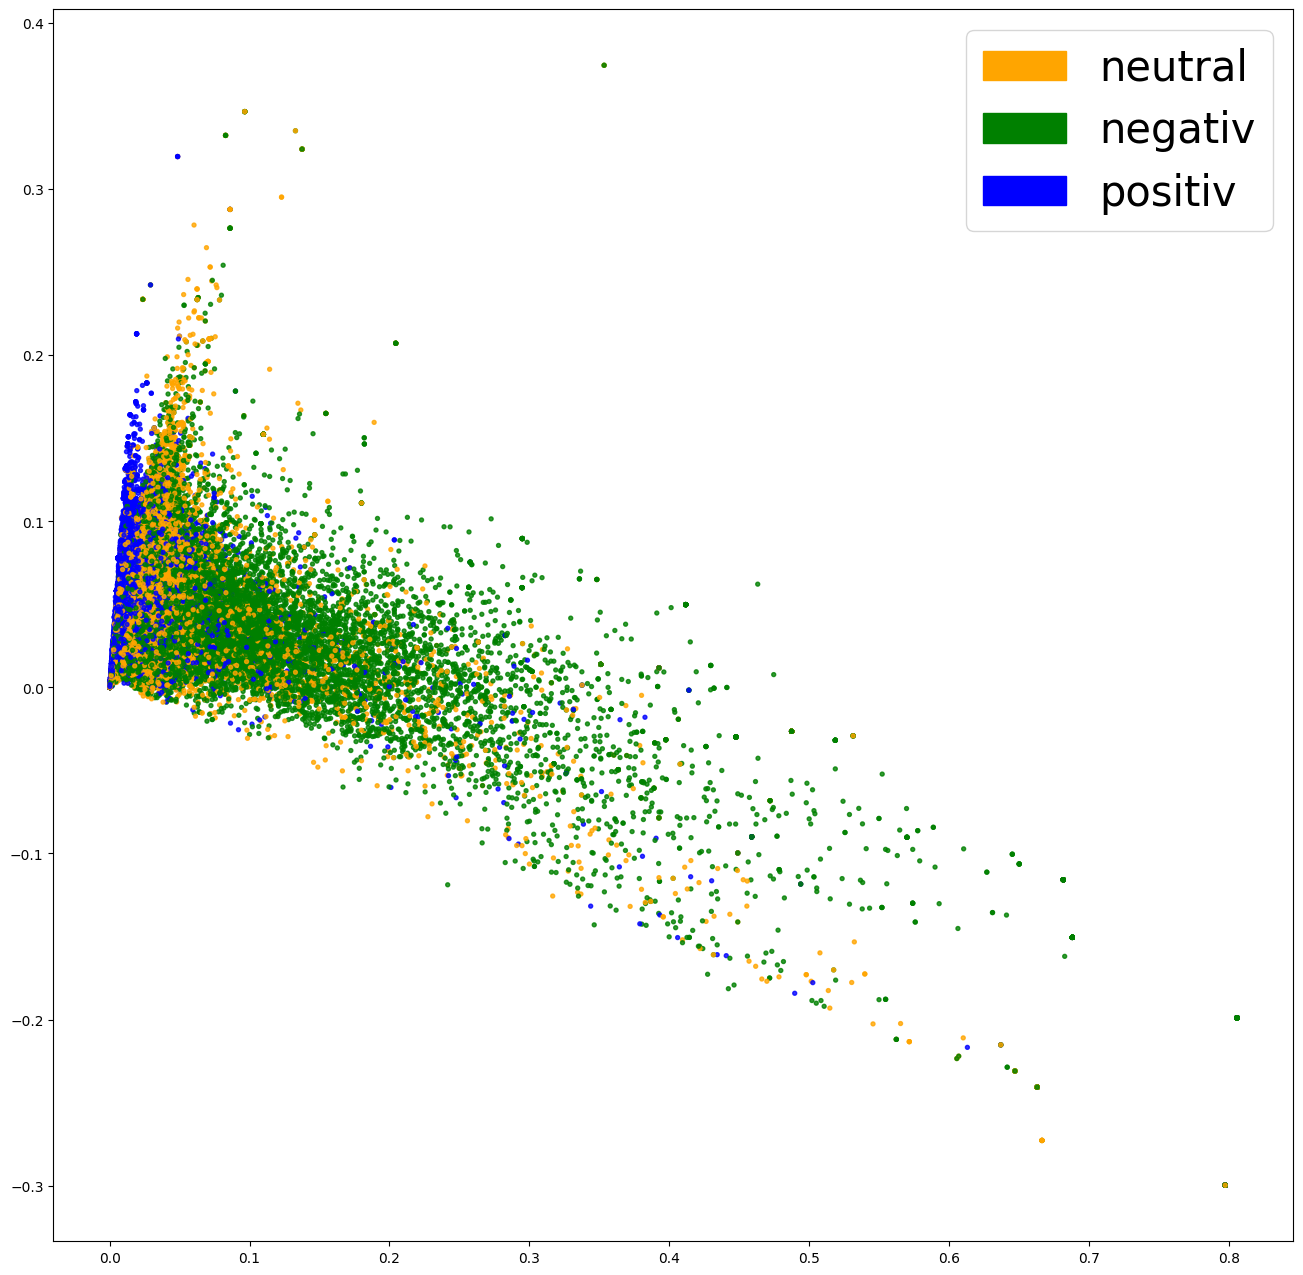

In [29]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plt.show()

визуально разделение не четкое

In [30]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',random_state=42)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f"  % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf))


accuracy = 0.734, precision = 0.732, recall = 0.734, f1 = 0.733, r2 = 0.270


метрики чуть хуже чем у Bag of Words Counts

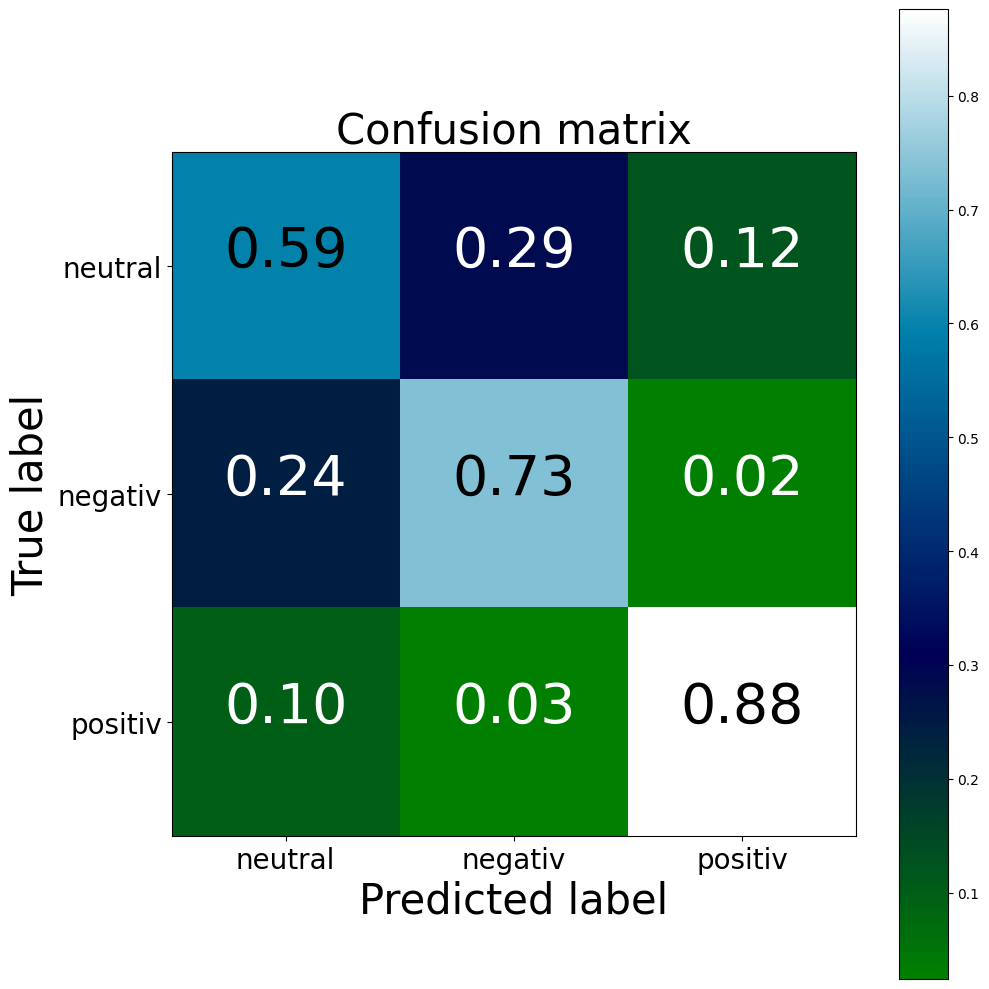

TFIDF confusion matrix
[[3450 1660  703]
 [1419 4317  142]
 [ 569  146 5059]]
BoW confusion matrix
[[3866 1314  633]
 [1631 4107  140]
 [ 683  117 4974]]


In [32]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['neutral','negativ','positiv'], normalize=True, title='Confusion matrix', cmap="ocean")
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

чуть лучше предсказывает классы positive и negative, но чаще ошибается на neutral

In [33]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

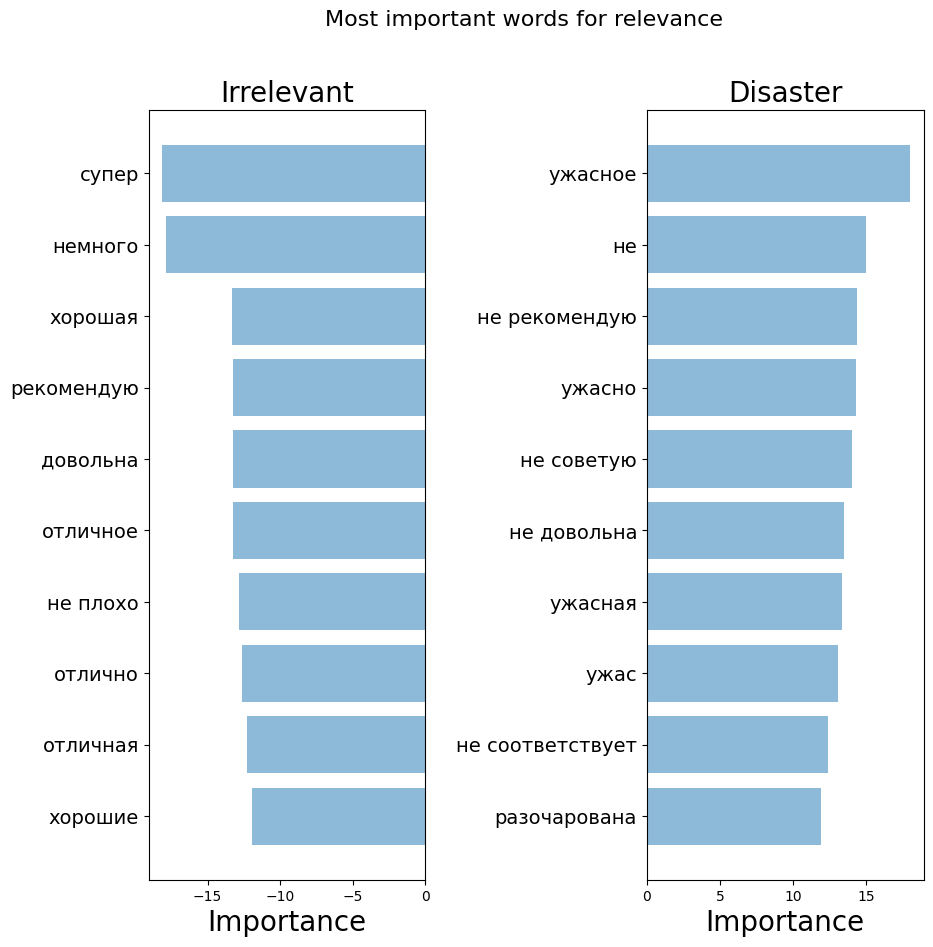

In [34]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

выбранные слова выглядят релевантными, но так же повторяются в разных формах

### Word2Vec

In [36]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.2 MB/s eta 0:00:00


In [37]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "/content/drive/MyDrive/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [38]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [39]:
embeddings = get_word2vec_embeddings(word2vec, df_clean)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,
                                                                                        test_size=0.2, random_state=40)

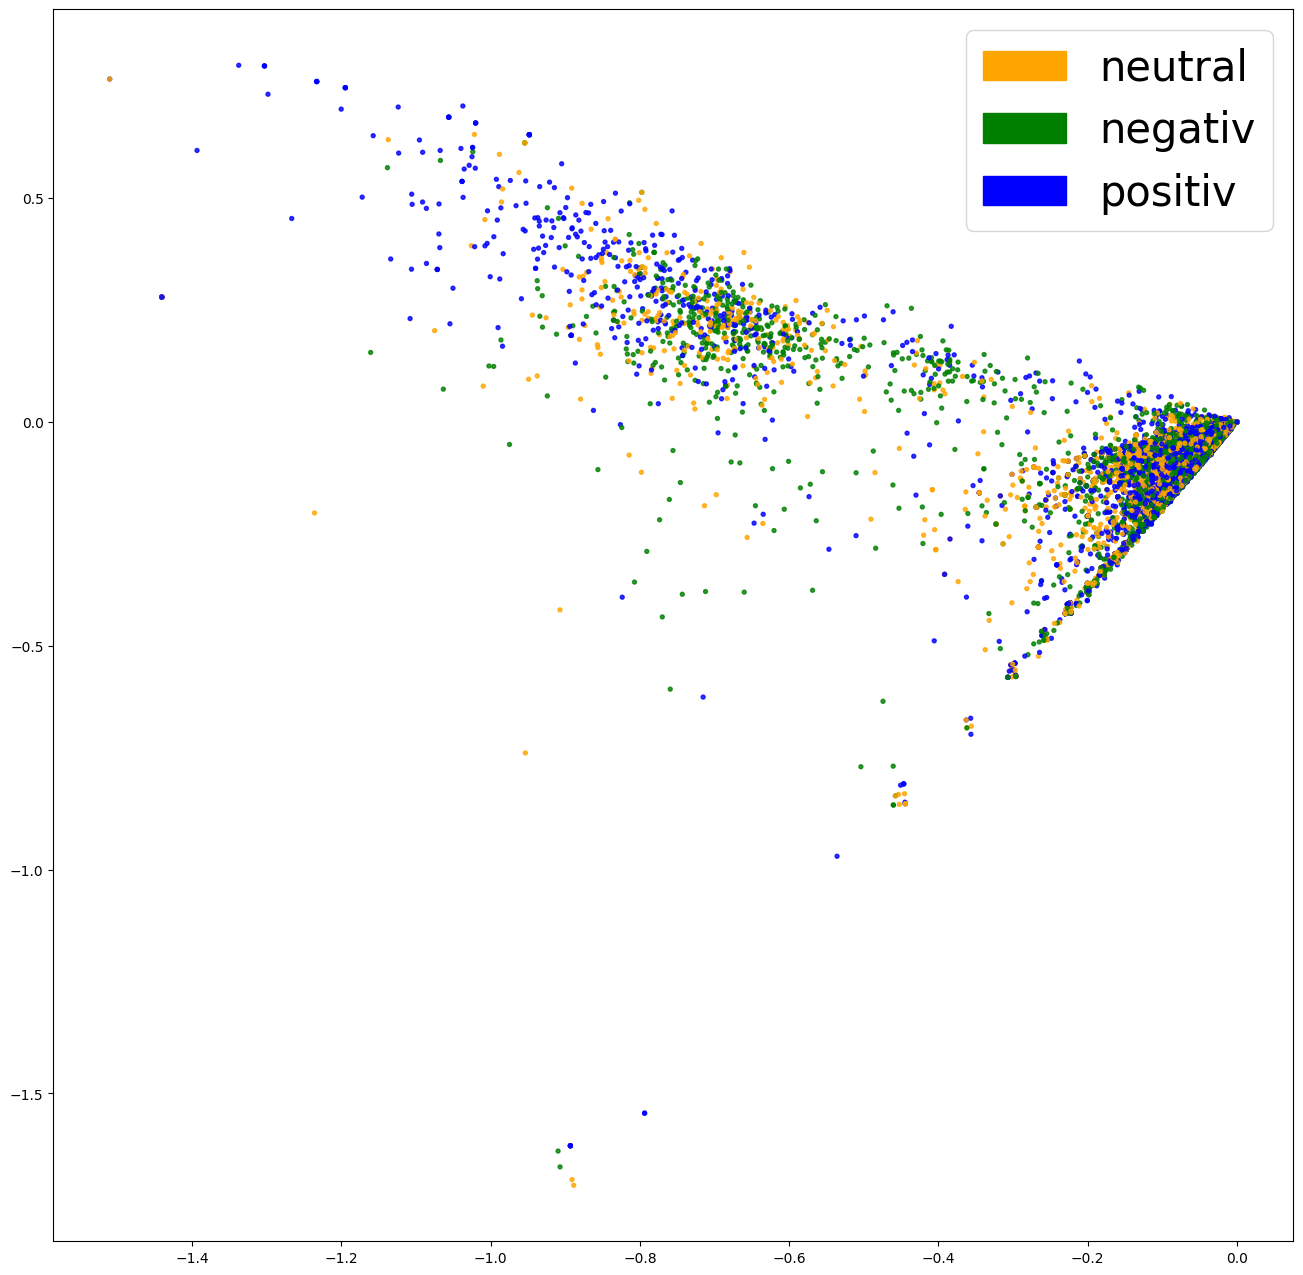

In [40]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(embeddings, list_labels)
plt.show()

разделение на классы не заметно

In [41]:
clf_w2v = LogisticRegression(class_weight='balanced',multi_class='multinomial', random_state=42)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [42]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec))

accuracy = 0.373, precision = 0.403, recall = 0.373, f1 = 0.290, r2 = -0.189


метрики намного хуже

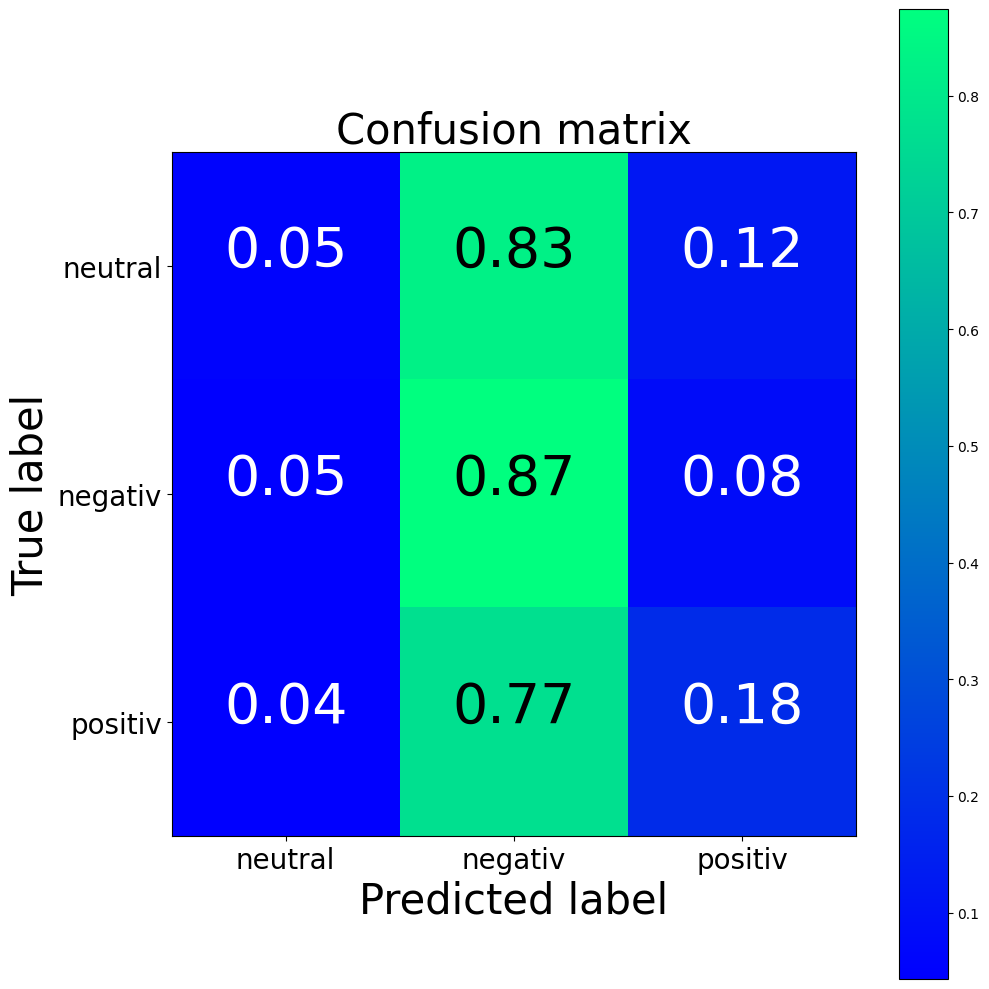

Word2Vec confusion matrix
[[ 308 4811  694]
 [ 266 5139  473]
 [ 249 4458 1067]]
TFIDF confusion matrix
[[3450 1660  703]
 [1419 4317  142]
 [ 569  146 5059]]
BoW confusion matrix
[[3866 1314  633]
 [1631 4107  140]
 [ 683  117 4974]]


In [43]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['neutral','negativ','positiv'], normalize=True, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

в основном предсказан класс negtive, так модель лучше других предсказала правильно этот класс, но сильно ошиблась с другими

### LIME

In [167]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c5add53a95a3edfdf1da560bdfbd0e439e760b8103167ddaf1d8026e87e099c4
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [168]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = TreebankWordTokenizer()
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [169]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ['neutral','negativ','positiv']):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [170]:
visualize_one_exp(X_test_data, y_test_data, 65)

Index: 65
True class: positiv


In [171]:
visualize_one_exp(X_test_data, y_test_data, 1000)

Index: 1000
True class: neutral


In [199]:
visualize_one_exp(X_test_data, y_test_data, 2)

Index: 2
True class: negativ


In [174]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()

    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)

    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)

        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]

    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'neutral',
    1: 'negative',
    2: 'positive'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

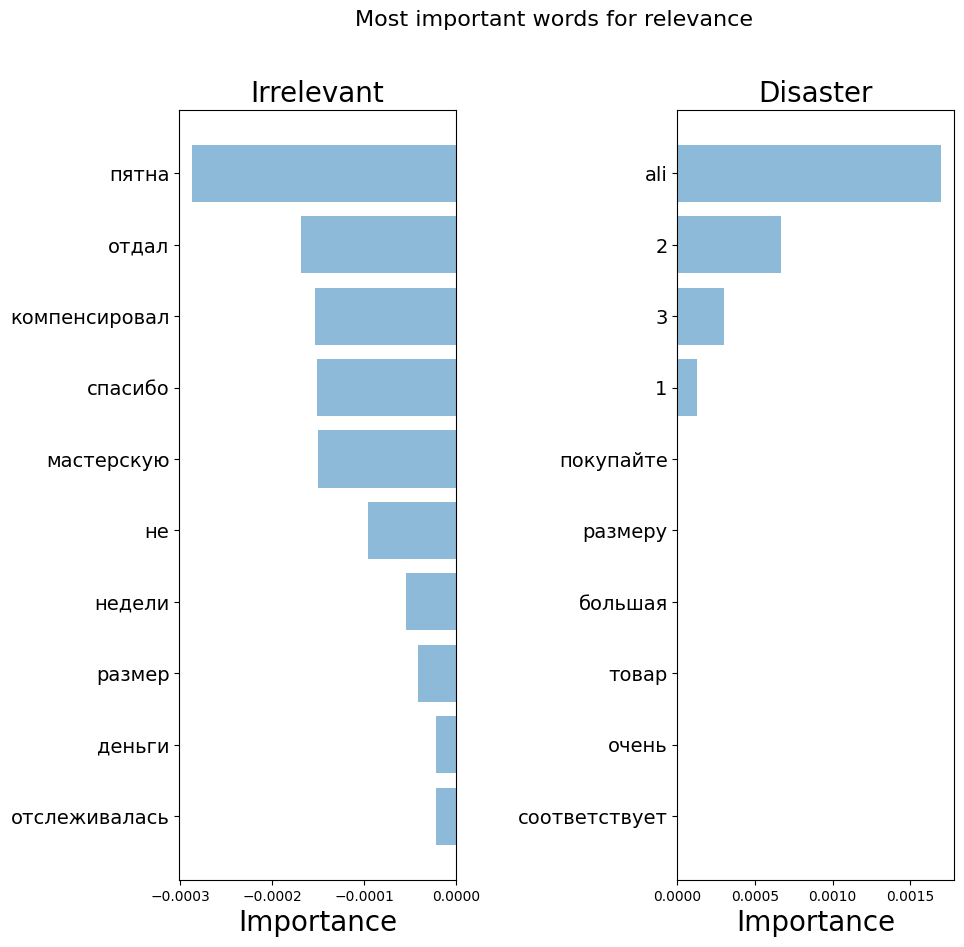

In [175]:
top_words = sorted_contributions['negative']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['negative']['supporters'][:10].tolist()
bottom_words = sorted_contributions['negative']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['negative']['detractors'][:10].tolist()
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### CNN

In [187]:
from tensorflow.keras.preprocessing.text  import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df_clean['review'].tolist())
sequences = tokenizer.texts_to_sequences(df_clean['review'].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(df_clean["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 53076 unique tokens.
(53077, 300)


In [190]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, BatchNormalization
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):

    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [2,3,4,5,7]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=256, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_norm = BatchNormalization()(l_conv)
        l_pool = MaxPooling1D(pool_size=3)(l_norm)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=256, kernel_size=3, activation='relu')(embedded_sequences)
    norm = BatchNormalization()(conv)
    pool = MaxPooling1D(pool_size=3)(norm)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [191]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM,
                len(list(df_clean["class_label"].unique())), False)

In [193]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=256)

Epoch 1/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - acc: 0.4697 - loss: 1.0987 - val_acc: 0.5778 - val_loss: 0.8796
Epoch 2/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - acc: 0.6196 - loss: 0.7994 - val_acc: 0.5086 - val_loss: 1.0856
Epoch 3/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - acc: 0.6476 - loss: 0.7495 - val_acc: 0.6659 - val_loss: 0.7207
Epoch 4/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - acc: 0.6678 - loss: 0.7129 - val_acc: 0.6663 - val_loss: 0.7186
Epoch 5/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - acc: 0.6831 - loss: 0.6938 - val_acc: 0.6809 - val_loss: 0.6988


In [194]:
y_pred = model.predict(x_val)

546/546 ━━━━━━━━━━━━━━━━━━━━ 43s 78ms/step


In [195]:
y_pred_cnn = np.argmax(y_pred, axis=1)
y_val_cnn = np.argmax(y_val, axis=1)

In [196]:
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn = get_metrics(y_val_cnn, y_pred_cnn)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn))

accuracy = 0.681, precision = 0.701, recall = 0.681, f1 = 0.680, r2 = 0.010


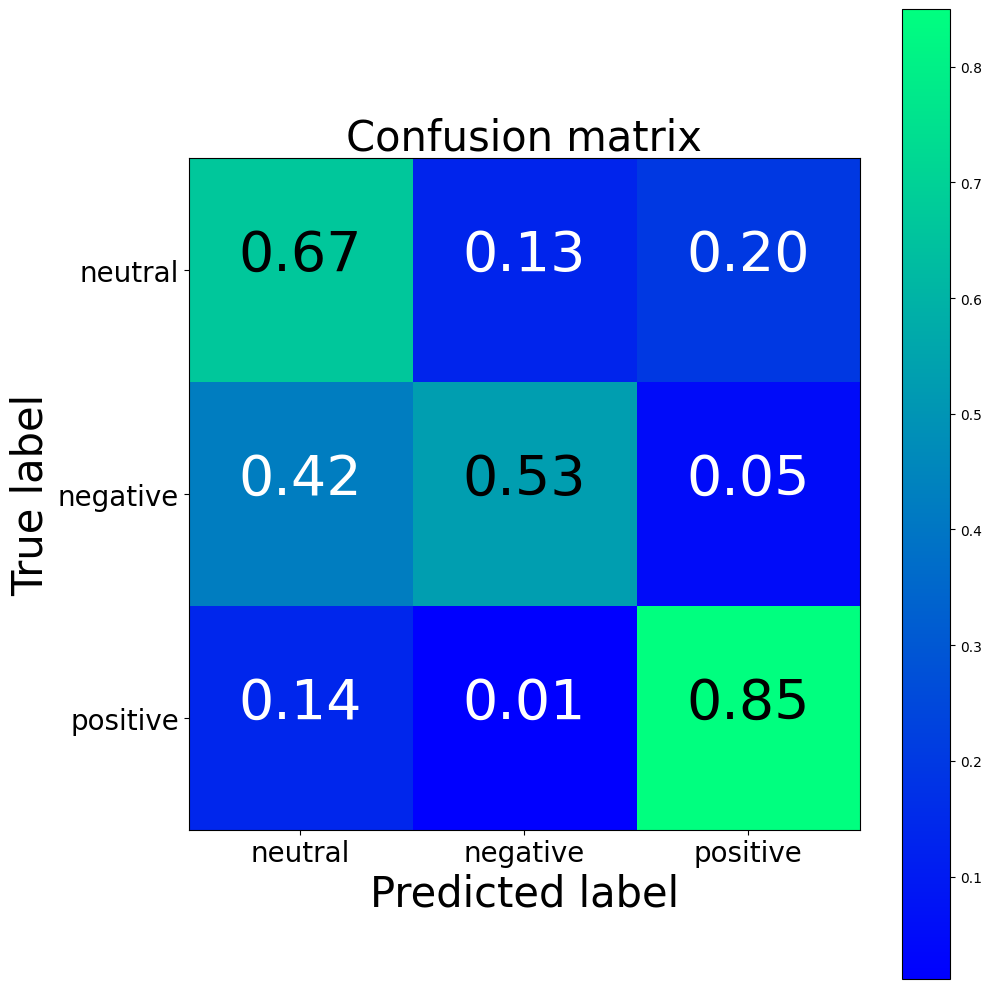

CNN confusion matrix
[[3831  768 1150]
 [2490 3123  291]
 [ 806   67 4938]]
Word2Vec confusion matrix
[[ 297 4764  625]
 [ 263 5108  526]
 [ 274 4559 1049]]
TFIDF confusion matrix
[[3464 1529  693]
 [1489 4264  144]
 [ 646  141 5095]]
BoW confusion matrix
[[3811 1268  607]
 [1692 4075  130]
 [ 721  113 5048]]


In [197]:
cm_cnn = confusion_matrix(y_val_cnn, y_pred_cnn)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_cnn, classes=['neutral','negative','positive'], normalize=True, title='Confusion matrix')
plt.show()

print("CNN confusion matrix")
print(cm_cnn)
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

лучше всего справились TFIDF и BoW